# 일원분산분석 NOVA (분산분석)

세 개 이상의 집단 간 평균의 차이를 검증하기 위해 사용된다.

분산분석에는 일원분산분석(One-Way ANOVA)과 이원분산분석(Two-Way ANOVA)이 있다.

분산분석의 결과가 통계적으로 유의하다는 결론을 얻었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지를 검증하기 위해 사후검정을 수행할 수 있다.

## #01. 준비작업

### [1] 패키지 참조

`pingouin` 패키지의 설치가 필요하다

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from matplotlib import pyplot as plt
from pandas import read_excel, melt
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

### [3] 데이터 가져오기

동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간 일별 매출액을 기록한 가상의 데이터이다.

이 데이터를 사용하여 두 매장의 평균을 비교하라.

In [3]:
origin = read_excel("https://data.hossam.kr/mldata/store.xlsx")
origin

,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58
...,...,...
95,53,69
96,52,51
97,52,65
98,49,59


## #02. 커널 밀도함수 및 신뢰구간 확인

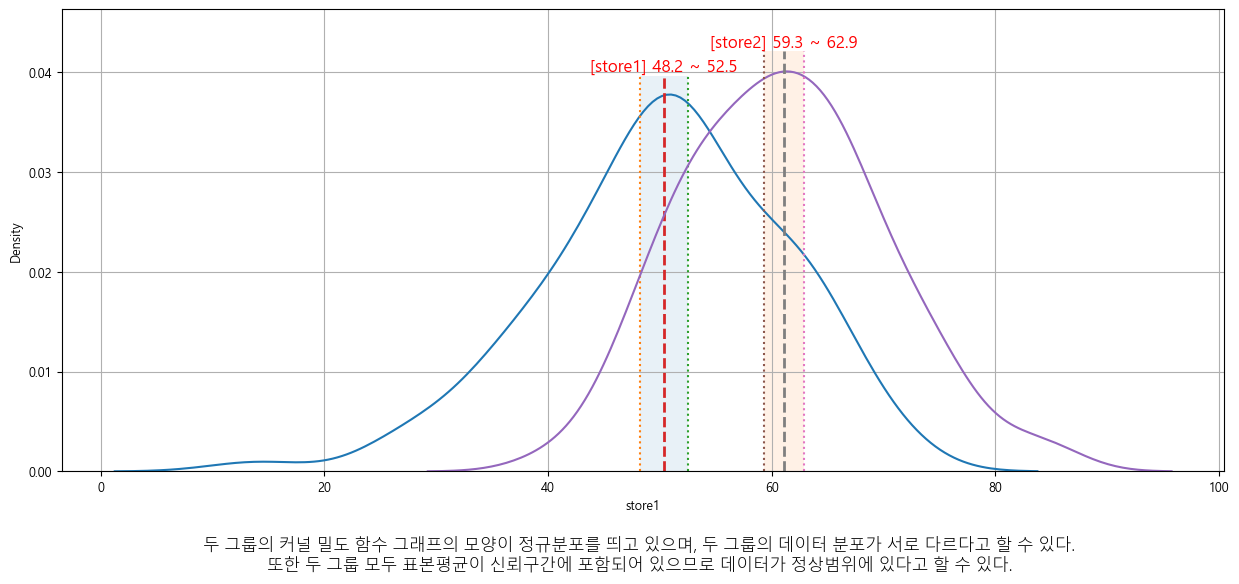

In [14]:
plt.figure()

for c in origin.columns:
    #print(c)
    
    data = origin[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.grid()
plt.show()
plt.close()

## #03. 분산분석의 가정 확인

### [1] 정규성 검정

In [5]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[store1] statistic: 5.651, p-value: 0.059, 정규성 충족 여부: True
[store2] statistic: 1.174, p-value: 0.556, 정규성 충족 여부: True


### [2] 등분산성 검정

In [6]:
normal_dist = True      # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 2.844, p-value: 0.092, 등분산성 충족 여부: True


> 가즈아~!!

## #04. 일원분산분석 수행

### [1] `scipy` 패키지 사용

분산분석을 수행할 변수를 파라미터로 전달한다.

등분산성을 만족하지 않을 경우 `equal_var=False` 파라미터를 함께 설정한다.

In [7]:
s, p = f_oneway(origin['store1'], origin['store2'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

귀무가설 : 모든 집단의 평균이 다르지 않다

대립가설 : 어느 한 집단의 평균은 다르다

`p-value`가 0.05보다 작으므로 귀무가설을 기각하고 대립가설을 채택한다.

즉, 두 가게의 일별 매출 평균은 다르다.

### [2] `statsmodels` 패키지 사용

#### (1) 데이터 전처리

명목형 변수와 연속형 변수로 구성된 형태로 데이터를 재배치 해야 한다.

In [8]:
df = melt(origin, var_name='store', value_name='sales')
df # store : 독립변수 , sales : 종속변수 // 독립변수에 따라 종속변수가 결정됨 

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


#### (2) 분산분석

데이터가 등분산성을 만족하지 않을 경우 `anova_lm()` 함수에 `robust='hc3'` 파라미터를 사용하여 uber-White 추정치를 사용한다.

In [18]:
lm = ols('sales ~ C(store)', data=df).fit() # y = ax+b :: sales ~ C(store) ; R에서 쓰는 형식
anova = anova_lm(lm)
print(anova)
# PR(>F) : p-value, F : statistic

             df     sum_sq      mean_sq          F        PR(>F)
C(store)    1.0   5735.205  5735.205000  58.717529  7.945482e-13
Residual  198.0  19339.550    97.674495        NaN           NaN


In [10]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

## #05. 사후검정 (post hoc)

ANOVA의 결과를 통해 두 집단의 분산에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

### [1] 사후검정의 가정

| 가설 | 내용 |
|---|---|
| 귀무가설 | 집단간 분산이 차이가 없다(다르지 않다) |
| 대립가설 | 집단간 분산이 차이가 있다(다르다) |

### [2] 사후검정의 종류

| 종류 | 사용 |
|---|---|
| 투키의 HSD | 등분산이고 샘플수가 동일한 경우 |
| 본페로니 교정, 피셔의 LSD, 셰페의 방법 | 등분산이고 샘플수가 다른 경우 |
| Games Howell | 등분산이 아닌 경우 |

`피셔의 LSD`와 `셰페의 방법`은 검정력이 다소 약하기 때문에 잘 사용되지 않는다.

### [3] 투키의 HSD

`Tuckey's Honestly Significant Difference` = "진정으로 유의미한 차이"

`OO`(명목형)에 따른 `ㅁㅁ`(연속형)의 차이라는 의미로 접근한다.

연속형 변수와 각 데이터를 구별할 수 있는 명목형 변수 순으로 파라미터를 설정한다.

In [11]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
store1,store2,10.71,0.0,7.9538,13.4662,True


> 사후 분석 결과 `store`에 따른 `sales`의 차이는 통계적으로 유의미하였다.($P<0.05$)
>
> store1과 store2의 평균은 `10.71`정도의 차이가 있으며 `95%`신뢰구간은 `7.9538~13.4462`인 것으로 나타났다.

### [4] 본페로니 교정

원래는 집단간 샘플 수가 동일하지 않을 경우 수행되는 방법이지만 여기서는 소스코드 확인을 위해 진행한다.

다소 엄격한 기각역을 설정하고 있기 때문에 제2종 오류 발생 위험이 있다.

검정 결과에서 `pval_corr`값이 `0.05`보다 작은 항목간의 비교에서 통계적으로 유의미한 차이가 있다고 해석한다.

In [12]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0] 
# pval_corr : p-value로 본다.
# 3개 이상의 집단일 경우 2개씩 비교를해서 결과값을 준다. (1-2, 1-3, 2-3)

group1,group2,stat,pval,pval_corr,reject
store1,store2,-7.6627,0.0,0.0,True


> 본페로니 교정 결과 `store1`과 `store2`의 평균은 통계적으로 유의미한 차이가 있다($P<0.05$)

### [5] Games-Howell 검정

`Games-Howell` 검정은 다수의 그룹 간의 평균 차이를 비교하는 통계적 방법 중 하나로, 등분산성 가정이 만족되지 않을 때 사용된다.

이 예제에 적합한 방법은 아니지만 소스코드의 제시를 목적으로 사용한다.

`scipy` 라이브러리에는 `Games-Howell` 검정을 직접 지원하는 함수는 없지만, `pingouin` 라이브러리를 사용하여 `Games-Howell` 검정을 수행할 수 있다.

In [13]:
result = pairwise_gameshowell(df, dv='sales', between='store')
result # 유의미한 변수 : mean, diff, pval 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565
